In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential, Input, load_model

In [3]:
hastalık_tipi=['COVID', 'non-COVID']
veri_adresi = ("../input/sarscov2-ctscan-dataset/")
train_dir = os.path.join(veri_adresi)

In [4]:
train_data=[]
for tur_id, sp in enumerate(hastalık_tipi):
    for dosya in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, dosya), tur_id, sp])
        
train = pd.DataFrame(train_data, columns=['Dosya', 'turID','Hastalık Tipi'])
train.head()

,Dosya,turID,Hastalık Tipi
0,COVID/Covid (230).png,0,COVID
1,COVID/Covid (1195).png,0,COVID
2,COVID/Covid (182).png,0,COVID
3,COVID/Covid (817).png,0,COVID
4,COVID/Covid (631).png,0,COVID


In [5]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train))
train.head()

,Dosya,turID,Hastalık Tipi
0,COVID/Covid (54).png,0,COVID
1,COVID/Covid (1035).png,0,COVID
2,non-COVID/Non-Covid (21).png,1,non-COVID
3,non-COVID/Non-Covid (248).png,1,non-COVID
4,COVID/Covid (409).png,0,COVID


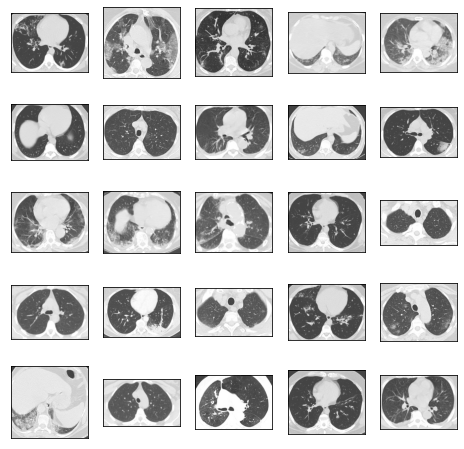

In [6]:
def plot_defects(hastalık_tipi, satir, sutun):
    fig, ax = plt.subplots(satir, sutun, figsize=(8, 8))
    dosya = train['Dosya'][train['Hastalık Tipi'] == hastalık_tipi].values
    n = 0
    for i in range(satir):
        for j in range(sutun):
            
            image_path = os.path.join(veri_adresi, dosya[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
plot_defects('COVID', 5, 5)

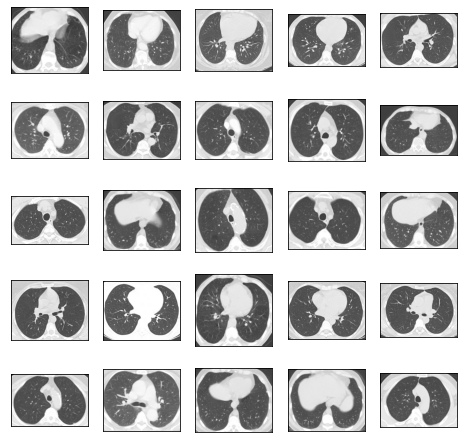

In [7]:
def plot_defects(hastalık_tipi, satir, sutun):
    fig, ax = plt.subplots(satir, sutun, figsize=(8, 8))
    dosya = train['Dosya'][train['Hastalık Tipi'] == hastalık_tipi].values
    n = 0
    for i in range(satir):
        for j in range(sutun):
            image_path = os.path.join(veri_adresi, dosya[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_defects('non-COVID', 5, 5) 

In [8]:
IMAGE_SIZE = 227
def read_image(dosya_yolu):
    return cv2.imread(os.path.join(train_dir, dosya_yolu))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['Dosya'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

Y_train = train['turID'].values
Y_train = to_categorical(Y_train, num_classes=2)

2481it [00:30, 80.62it/s]


Train Shape: (2481, 227, 227, 3)


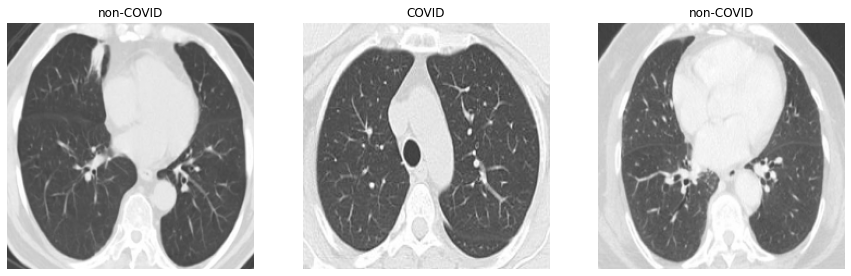

In [9]:
BATCH_SIZE = 64

X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.3, random_state=SEED)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(hastalık_tipi[np.argmax(Y_train[i])])

In [10]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",
                  activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())

#output layer
model.add(Dense(2,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         8

In [11]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])



In [12]:
model.fit(X_train, Y_train, epochs=15)

Epoch 1/15
55/55 [==============================] - 82s 1s/step - loss: 0.7913 - accuracy: 0.6958
Epoch 2/15
55/55 [==============================] - 80s 1s/step - loss: 0.4803 - accuracy: 0.8017
Epoch 3/15
55/55 [==============================] - 82s 1s/step - loss: 0.4164 - accuracy: 0.8288
Epoch 4/15
55/55 [==============================] - 80s 1s/step - loss: 0.3732 - accuracy: 0.8507
Epoch 5/15
55/55 [==============================] - 80s 1s/step - loss: 0.4242 - accuracy: 0.8350
Epoch 6/15
55/55 [==============================] - 80s 1s/step - loss: 0.3124 - accuracy: 0.8686
Epoch 7/15
55/55 [==============================] - 81s 1s/step - loss: 0.2407 - accuracy: 0.9026
Epoch 8/15
55/55 [==============================] - 80s 1s/step - loss: 0.3252 - accuracy: 0.8625
Epoch 9/15
55/55 [==============================] - 80s 1s/step - loss: 0.3378 - accuracy: 0.8629
Epoch 10/15
55/55 [==============================] - 80s 1s/step - loss: 0.2591 - accuracy: 0.9036
Epoch 11/15
55/55 [

In [13]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Loss: {}, Accuracy: {},'
      .format(final_loss, final_accuracy))

24/24 [==============================] - 8s 335ms/step - loss: 0.9113 - accuracy: 0.7611
Loss: 0.9112714529037476, Accuracy: 0.7610738277435303,


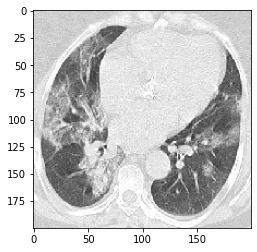

Prediction: ['Covid-19', 'Non Covid-19']


In [14]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('../input/sarscov2-ctscan-dataset/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('../input/sarscov2-ctscan-dataset/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

plt.imshow(show_img)
plt.show()


        
print('Prediction:',disease_class)

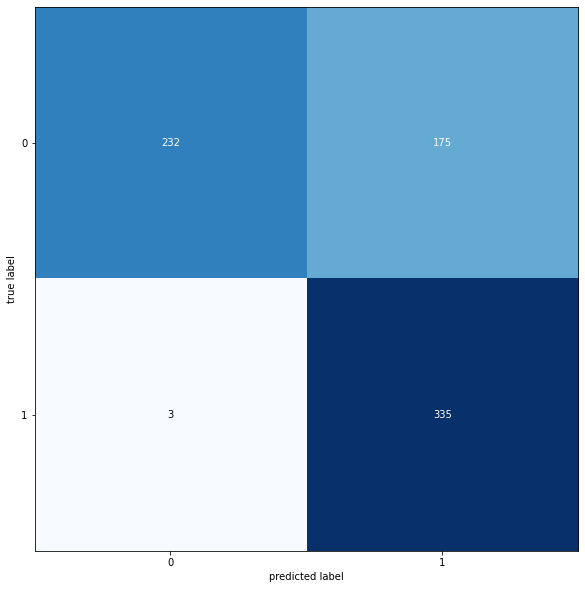

In [15]:

from sklearn.metrics import confusion_matrix
pred = model.predict(X_val)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(Y_val,axis = 1)


CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10, 10))
plt.show()